In [1]:
import os
import torch
import torch.nn as nn

#libraries for model generation
from list_to_model import CNN_list
from model import FaceRecognition

#libraries for data loading
import pickle
from torch.utils.data import DataLoader
from dataset_fr import datas

#libraries for recording training progress
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [2]:
base_path=os.path.join('lfw')

# Create the Model

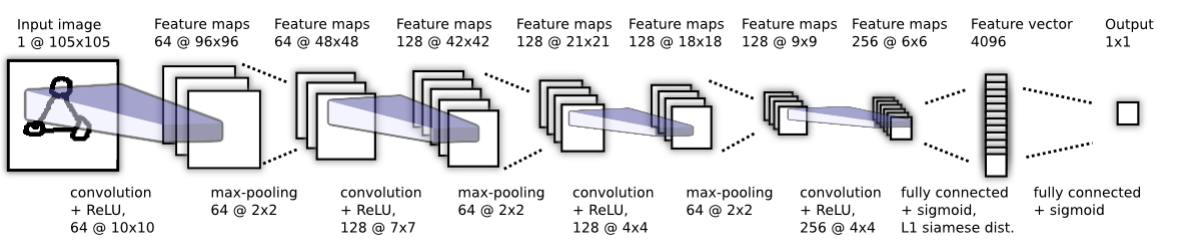

In [3]:
# Define the parameters used in the paper as a list
'''
    The paper needs us to set up the padding as 'same' in the MaxPool layers. Padding is 'same' when for a stride of 1, 
    the output size = input size
    Wout=((Win + 2*padding-kernel_size)/stride)+1 --------------- (1)
    So if we apply the conditions:
        a. Wout=Win and 
        b. stride=1 in (1), we get:
    we get:
        padding=ceiling(1-kernel_size)/2 ------------------------------------(2) since padding has to be non negative integer
    We apply this calculation to Maxpool layers below to get padding for all layers as 0
'''

conv_list=[
            [
                [{'Conv':[{'out_channels':64,'kernel_size':10},1]},
                 {'Max_Pool':[{'kernel_size':2,'stride':2,'padding':0},1]}    
                ],
                1                 
            ],
            [
                [{'Conv':[{'out_channels':128,'kernel_size':7},1]},
                 {'Max_Pool':[{'kernel_size':2,'stride':2,'padding':0},1]}    
                ],
                1                 
            ],
            [
                [{'Conv':[{'out_channels':128,'kernel_size':4},1]},
                 {'Max_Pool':[{'kernel_size':2,'stride':2,'padding':0},1]}    
                ],
                1                 
            ],
            [
                [{'Conv':[{'out_channels':256,'kernel_size':4},1]},  
                ],
                1                 
            ],
            
        ]
dense_list1=[
    [
                [{'Dense':[{'out_features':4096},1]}] 
                , 1                 
            ]
]
    
dense_list2=[
    [
                [{'Dense':[{'out_features':1},1]}] 
                , 1                 
            ]
]

In [4]:
#Compiling the list of parameters as layers
cnn_layers=CNN_list()
cnn_layers.build_conv_model(conv_list,3)
conv=cnn_layers.model
print('\033[1m' + 'Convolutional layers'+ '\033[0m')
for c in conv:
    print(c)
dense_layers1=CNN_list()
dense_layers1.build_dense_model(dense_list1,9216)
dense_layers1.model.pop(-1)
dense1=dense_layers1.model
print('\n\033[1m' + 'Pre-distance calculation Dense layer'+ '\033[0m')
for d in dense_layers1.model:
    print(d)
dense_layers2=CNN_list()
dense_layers2.build_dense_model(dense_list2,4096)
dense_layers2.model.pop(-1)
dense2=dense_layers2.model
print('\n\033[1m' + 'Post-distance calculation Dense layer'+ '\033[0m')
for d in dense_layers2.model:
    print(d)

Convolutional layers
Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
ReLU()

Pre-distance calculation Dense layer
Linear(in_features=9216, out_features=4096, bias=True)

Post-distance calculation Dense layer
Linear(in_features=4096, out_features=1, bias=True)


In [5]:
fr=FaceRecognition(conv,dense1, dense2).cuda()
criterion=nn.BCELoss()
optim=torch.optim.Adam(fr.parameters(), lr=1e-5)

## Creating the DataLoader

In [6]:
inputFile = 'total.data'
fd = open(inputFile, 'rb')
total_images = pickle.load(fd)

In [7]:
faces=datas(total_images,base_path) #Customized dataset class

In [8]:
len(faces)

40337

In [9]:
train_split=0.8
test_split=1-train_split
train_len=int(train_split*len(faces))
test_len=len(faces)-train_len
print('Training set size: ',train_len)
print('Test set size: ',test_len)

Training set size:  32269
Test set size:  8068


In [10]:
train_set, test_set = torch.utils.data.random_split(faces, [train_len, test_len])

In [11]:
train_loader=DataLoader(train_set, batch_size=256,shuffle=True, drop_last=True)
test_loader=DataLoader(test_set, batch_size=256,shuffle=True, drop_last=True)

## Training the model

In [12]:
def acc(y_pred,y_actual):
    y_round=(y_pred>0.5).float()
    return torch.sum(y_round==y_actual).float()/len(y_pred)

In [13]:
def train(model,img_set1,img_set2,labels):
    yhat=model(img_set1,img_set2)
    loss=criterion(yhat,labels)
    acc1=acc(yhat,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss,acc1

In [14]:
def test(model,img_set1,img_set2,labels):
    yhat=model(img_set1,img_set2)
    loss=criterion(yhat,labels)
    acc1=acc(yhat,labels)
    return loss,acc1

In [15]:
#Creating tensorboard logs
log_path=os.path.join('logs')
writer=SummaryWriter(log_dir=log_path)

In [16]:
epochs=100

In [17]:
epoch_tr_losses=[]
epoch_tr_accuracy=[]
epoch_te_losses=[]
epoch_te_accuracy=[]
for i in tqdm(range(epochs)):
    batch_tr_loss=[]
    batch_tr_accuracy=[]
    for train_batch in train_loader:
        anchor_train,reference_train,y_train=train_batch
        batch_train_loss, batch_train_accuracy=train(fr,anchor_train.cuda(),reference_train.cuda(),y_train.cuda())
        batch_tr_accuracy.append(batch_train_accuracy)
        batch_tr_loss.append(batch_train_loss)
    avg_tr_epoch_loss=torch.mean(torch.stack(batch_tr_loss)).item()
    avg_tr_epoch_accuracy=torch.mean(torch.stack(batch_tr_accuracy)).item()
    epoch_tr_losses.append(avg_tr_epoch_loss)
    epoch_tr_accuracy.append(avg_tr_epoch_accuracy)
    writer.add_scalar('Last Batch Loss of the epoch/train', batch_train_loss,i)
    writer.add_scalar('Last Batch Accuracy of the epoch/train', batch_train_accuracy,i)
    writer.add_scalar('Average Loss of the epoch/train', avg_tr_epoch_loss,i)
    writer.add_scalar('Average Accuracy of the epoch/train', avg_tr_epoch_accuracy,i)
    
    with torch.no_grad():
        batch_te_loss=[]
        batch_te_accuracy=[]
        for test_batch in test_loader:
            anchor_test,reference_test,y_test=test_batch
            batch_test_loss, batch_test_accuracy=test(fr,anchor_test.cuda(),reference_test.cuda(),y_test.cuda())
            batch_te_accuracy.append(batch_test_accuracy)
            batch_te_loss.append(batch_test_loss)
        avg_te_epoch_loss=torch.mean(torch.stack(batch_te_loss)).item()
        avg_te_epoch_accuracy=torch.mean(torch.stack(batch_te_accuracy)).item()
        epoch_te_losses.append(avg_te_epoch_loss)
        epoch_te_accuracy.append(avg_te_epoch_accuracy)
        writer.add_scalar('Last Batch Loss of the epoch/test', batch_test_loss,i)
        writer.add_scalar('Last Batch Accuracy of the epoch/test', batch_test_accuracy,i)
        writer.add_scalar('Average Loss of the epoch/test', avg_te_epoch_loss,i)
        writer.add_scalar('Average Accuracy of the epoch/test', avg_te_epoch_accuracy,i)
    
    if (i+1)%100==0:
        print(f'Average training loss after {i} epochs is {avg_tr_epoch_loss} and the average training accuracy is {avg_tr_epoch_accuracy}')
        print(f'Average testing loss after {i} epochs is {avg_te_epoch_loss} and the average training accuracy is {avg_te_epoch_accuracy}')
writer.close()

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [3:28:17<00:00, 124.97s/it]

Average training loss after 99 epochs is 0.00019741781579796225 and the average training accuracy is 1.0
Average testing loss after 99 epochs is 0.28482115268707275 and the average training accuracy is 0.9065020084381104


In [20]:
avg_te_epoch_loss

0.28482115268707275

In [21]:
avg_te_epoch_accuracy

0.9065020084381104

In [22]:
torch.save(fr,'face_recognition.pt')